In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# 그래프 기본 테마 설정
sns.set_style("white")
sns.set_context("notebook")

# 폰트 적용
import platform
from matplotlib import font_manager as fm
font_path = "font/NanumGothic.ttf"

font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.facecolor'] = 'white'      # 축 배경 흰색
plt.rcParams['figure.facecolor'] = 'white'    # 전체 배경 흰색
plt.rcParams['axes.grid'] = False             # 그리드 제거
plt.rcParams['savefig.facecolor'] = 'white'   # 저장 이미지 배경도 흰색

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 복잡한 통계 처리를 위한 라이브러리
from scipy import stats

In [3]:
df = pd.read_csv('data/merged_data_brand_dropna.csv')

In [4]:
# datetime 컬럼 변환
df['event_time_moscow'] = pd.to_datetime(df['event_time_moscow'])

## H19_cart 포함 세션이 view-only 세션보다 전환율이 높다.

In [4]:
# 세션 단위 이벤트 집계
session_event = df.pivot_table(
    index='user_session',
    columns='event_type',
    values='user_id',  # 또는 product_id 등 고유값
    aggfunc='nunique',
    fill_value=0
).reset_index()

# 전환 여부 플래그 (purchase가 있으면 1, 없으면 0)
session_event['converted'] = (session_event['purchase'] > 0).astype(int)

# 그룹 분리
session_event['group'] = session_event.apply(
    lambda row: 'cart' if row['cart'] > 0 else 'view_only', axis=1
)

In [7]:
# 그룹별 전환율 계산
conversion_by_group = session_event.groupby('group')['converted'].agg(['count', 'sum'])
conversion_by_group['conversion_rate'] = conversion_by_group['sum'] / conversion_by_group['count']

conversion_by_group

,count,sum,conversion_rate
group,,,
cart,722170,102469,0.141890
view_only,2343089,35384,0.015101


In [8]:
from scipy.stats import chi2_contingency

# 교차표 생성
contingency = pd.crosstab(session_event['group'], session_event['converted'])

# 카이제곱 검정
chi2, p, dof, expected = chi2_contingency(contingency)

print(f"카이제곱 통계량: {chi2:.4f}")
print(f"p-value: {p:.6f}")

카이제곱 통계량: 206610.8117
p-value: 0.000000


- **cart 포함 세션이 view-only 세션보다 전환율이 높다. → True**

## H20_구매 세션은 평균적으로 이벤트 수가 많다.

In [9]:
# 세션별 이벤트 수
session_event_count = df.groupby('user_session').size().reset_index(name='event_count')

# 세션별 구매 여부
session_purchase_flag = df.groupby('user_session')['event_type'].apply(lambda x: 'purchase' in x.values).reset_index(name='is_purchase')

# 병합
session_df = pd.merge(session_event_count, session_purchase_flag, on='user_session')

In [10]:
# 그룹 나누기
purchase_group = session_df[session_df['is_purchase'] == True]['event_count']
non_purchase_group = session_df[session_df['is_purchase'] == False]['event_count']

In [11]:
from scipy.stats import shapiro, levene

# 정규성
print("✅ Shapiro-Wilk Test (구매):", shapiro(purchase_group.sample(5000)))  # 너무 크면 샘플링
print("✅ Shapiro-Wilk Test (비구매):", shapiro(non_purchase_group.sample(5000)))

# 등분산성
print("✅ Levene 등분산성 Test:", levene(purchase_group, non_purchase_group))

✅ Shapiro-Wilk Test (구매): ShapiroResult(statistic=np.float64(0.24380772719552424), pvalue=np.float64(2.385225307201329e-89))
✅ Shapiro-Wilk Test (비구매): ShapiroResult(statistic=np.float64(0.3039849752668604), pvalue=np.float64(1.8304157381152818e-87))
✅ Levene 등분산성 Test: LeveneResult(statistic=np.float64(124344.60680329631), pvalue=np.float64(0.0))


In [12]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(purchase_group, non_purchase_group, alternative='greater')
print(f"✅ Mann-Whitney U test 통계량: {u_stat}")
print(f"✅ p-value: {p_value}")

✅ Mann-Whitney U test 통계량: 364015028363.5
✅ p-value: 0.0


In [13]:
from scipy.stats import mannwhitneyu

# 양측 검정
u_stat, p_value = mannwhitneyu(purchase_group, non_purchase_group, alternative='two-sided')

print(f"✅ Mann-Whitney U test 통계량: {u_stat}")
print(f"✅ p-value (양측): {p_value}")

✅ Mann-Whitney U test 통계량: 364015028363.5
✅ p-value (양측): 0.0


- 귀무가설 (H₀): 구매 세션과 비구매 세션의 이벤트 수 평균은 차이가 없다.
- 대립가설 (H₁): 구매 세션의 이벤트 수 평균이 더 크다.
- alternative='greater' : 단측 검정 (구매 세션의 이벤트 수 평균이 더 크다.)
    p-value = 0.0
- 양측 검정 역시 p-value = 0.0

- 구매 세션은 평균적으로 이벤트 수가 많다. → True
- **구매 세션은 비구매 세션보다 이벤트 수의 평균이 더 크다.**

## H21_remove_from_cart가 잦은 세션은 전환율이 낮다.

In [5]:
import pandas as pd
from scipy.stats import mannwhitneyu

# 세션 단위 집계
session_df = df.groupby('user_session')['event_type'].value_counts().unstack(fill_value=0).reset_index()

# 구매 전환율 (0 또는 1로)
session_df['converted'] = session_df['purchase'] > 0

# remove 비율 계산 (장바구니 기준)
session_df['remove_rate'] = session_df['remove_from_cart'] / (session_df['cart'] + 1e-6)

# 상위/하위 그룹 나누기 (예: remove_rate 기준 중앙값)
median = session_df['remove_rate'].median()
high_remove = session_df[session_df['remove_rate'] > median]['converted']
low_remove = session_df[session_df['remove_rate'] <= median]['converted']

# 평균 전환율 출력
print("✅ remove 높은 그룹 전환율:", high_remove.mean())
print("✅ remove 낮은 그룹 전환율:", low_remove.mean())

# Mann-Whitney U Test
u_stat, p_val = mannwhitneyu(low_remove, high_remove, alternative='less')
print("✅ Mann-Whitney U 통계량:", u_stat)
print("✅ p-value:", p_val)

✅ remove 높은 그룹 전환율: 0.19983421812924013
✅ remove 낮은 그룹 전환율: 0.023531836819586403
✅ Mann-Whitney U 통계량: 413372650730.5
✅ p-value: 0.0


- median 기준으로 상위 50%, 하위 50%로 분할
- greater (H1에서 전환율 : 상위 그룹 > 하위 그룹) → p-value = 1.0
- less (H1에서 전환율 : 상위 그룹 < 하위 그룹) → p-value = 0.0
- **remove_from_cart가 잦은 세션은 전환율이 낮다. → False**
- **세션에서 remove_from_cart의 비율이 높은 그룹이 구매 전환율이 높다.**

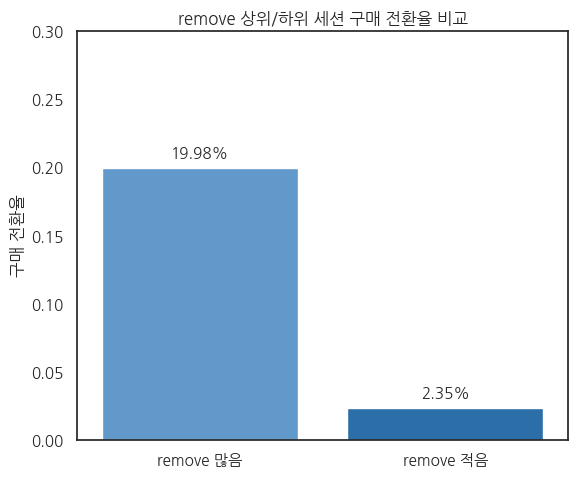

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 시각화용 데이터프레임 생성 (순서: 많음 → 적음)
plot_df = pd.DataFrame({
    'group': ['remove 많음', 'remove 적음'],
    'conversion_rate': [high_remove.mean(), low_remove.mean()]
})

# 시각화
plt.figure(figsize=(6, 5))
sns.barplot(
    data=plot_df,
    x='group',
    y='conversion_rate',
    order=['remove 많음', 'remove 적음'],
    palette=['#509adb', '#1770bd']
)

# 값 라벨 추가
for i, row in plot_df.set_index('group').loc[['remove 많음', 'remove 적음']].reset_index().iterrows():
    plt.text(
        i, row['conversion_rate'] + 0.005,
        f"{row['conversion_rate']*100:.2f}%", 
        ha='center', va='bottom', fontsize=11, fontweight='bold'
    )

# 레이아웃 설정
plt.title('remove 상위/하위 세션 구매 전환율 비교')
plt.ylabel('구매 전환율')
plt.xlabel('')
plt.ylim(0, 0.3)
plt.tight_layout()
plt.show()
